In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from torchvision.models import vgg19, VGG19_Weights

In [2]:
style_img = Image.open("./notebook_images/picasso.jpg")

In [3]:
img_size = 128

cnn_normalization_mean = [0.485, 0.456, 0.406]
cnn_normalization_std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=cnn_normalization_mean, std=cnn_normalization_std),
])

In [4]:
style_tensor = transform(style_img)
style_tensor = style_tensor.unsqueeze(0)
print(f"style_tensor shape: {style_tensor.shape}")

style_tensor shape: torch.Size([1, 3, 128, 128])


In [5]:
noise_tensor = torch.randn(1, 3, 128, 128)
print(f"noise_tneosr shape: {noise_tensor.shape}")

noise_tneosr shape: torch.Size([1, 3, 128, 128])


In [6]:
untransform = transforms.Compose([
    transforms.Normalize(
        mean=[-m / s for m, s in zip(cnn_normalization_mean, cnn_normalization_std)],
        std=[1 / s for s in cnn_normalization_std]
    ),
    transforms.ToPILImage(),
])

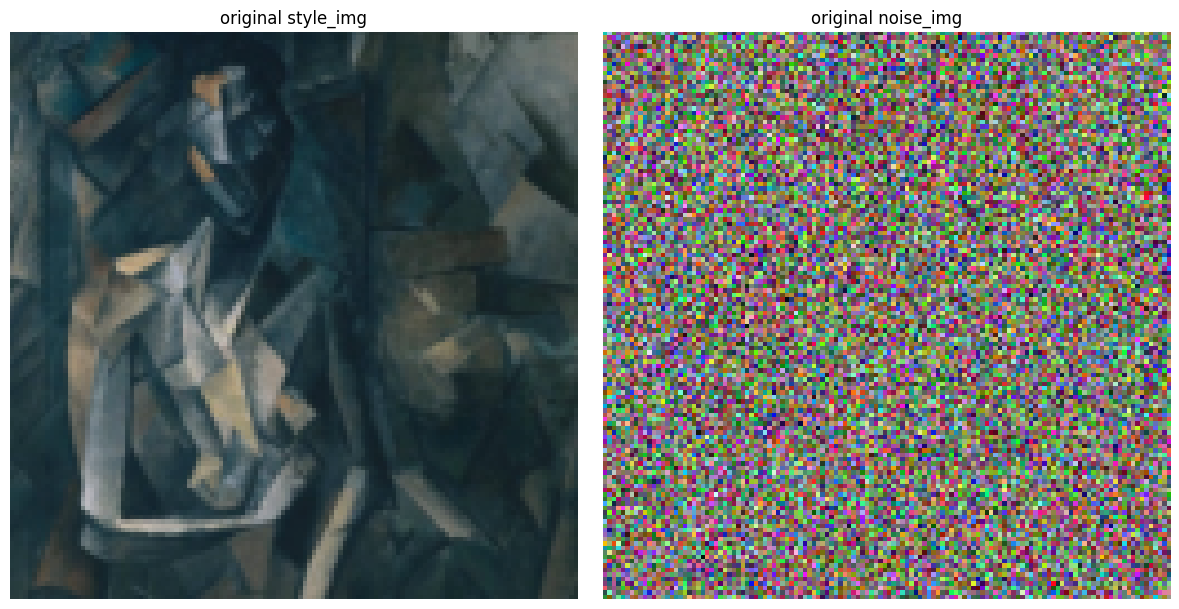

In [7]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(untransform(style_tensor.squeeze(0)))
plt.title("original style_img")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(untransform(noise_tensor.squeeze(0)))
plt.title("original noise_img")
plt.axis("off")

plt.tight_layout()
plt.show()

In [8]:
vgg19_model = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

model = nn.Sequential()
i = 0
for layer in vgg19_model.children():
    if isinstance(layer, nn.Conv2d):
        i += 1
        name = f'conv_{i}'
    elif isinstance(layer, nn.ReLU):
        name = f'relu_{i}'
        layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
        layer = nn.AvgPool2d(2, 2)
        name = f'pool_{i}'
    elif isinstance(layer, nn.BatchNorm2d):
        name = f'bn_{i}'
    
    model.add_module(name, layer)

    if name == f'conv_5':
        break

print(model)

Sequential(
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2): ReLU()
  (pool_2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_4): ReLU()
  (pool_4): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = model.to(device)
style_tensor_output = style_tensor.clone().to(device)
noise_tensor_output = noise_tensor.clone().to(device)

style_tensor_results = {}
noise_tensor_results = {}
for name, layer in model.named_children():
    with torch.no_grad():
        style_tensor_output.clamp_(0, 1)
        noise_tensor_output.clamp_(0, 1)

    style_tensor_output = layer(style_tensor_output)
    noise_tensor_output = layer(noise_tensor_output)

    style_tensor_results[name] = style_tensor_output
    noise_tensor_results[name] = noise_tensor_output

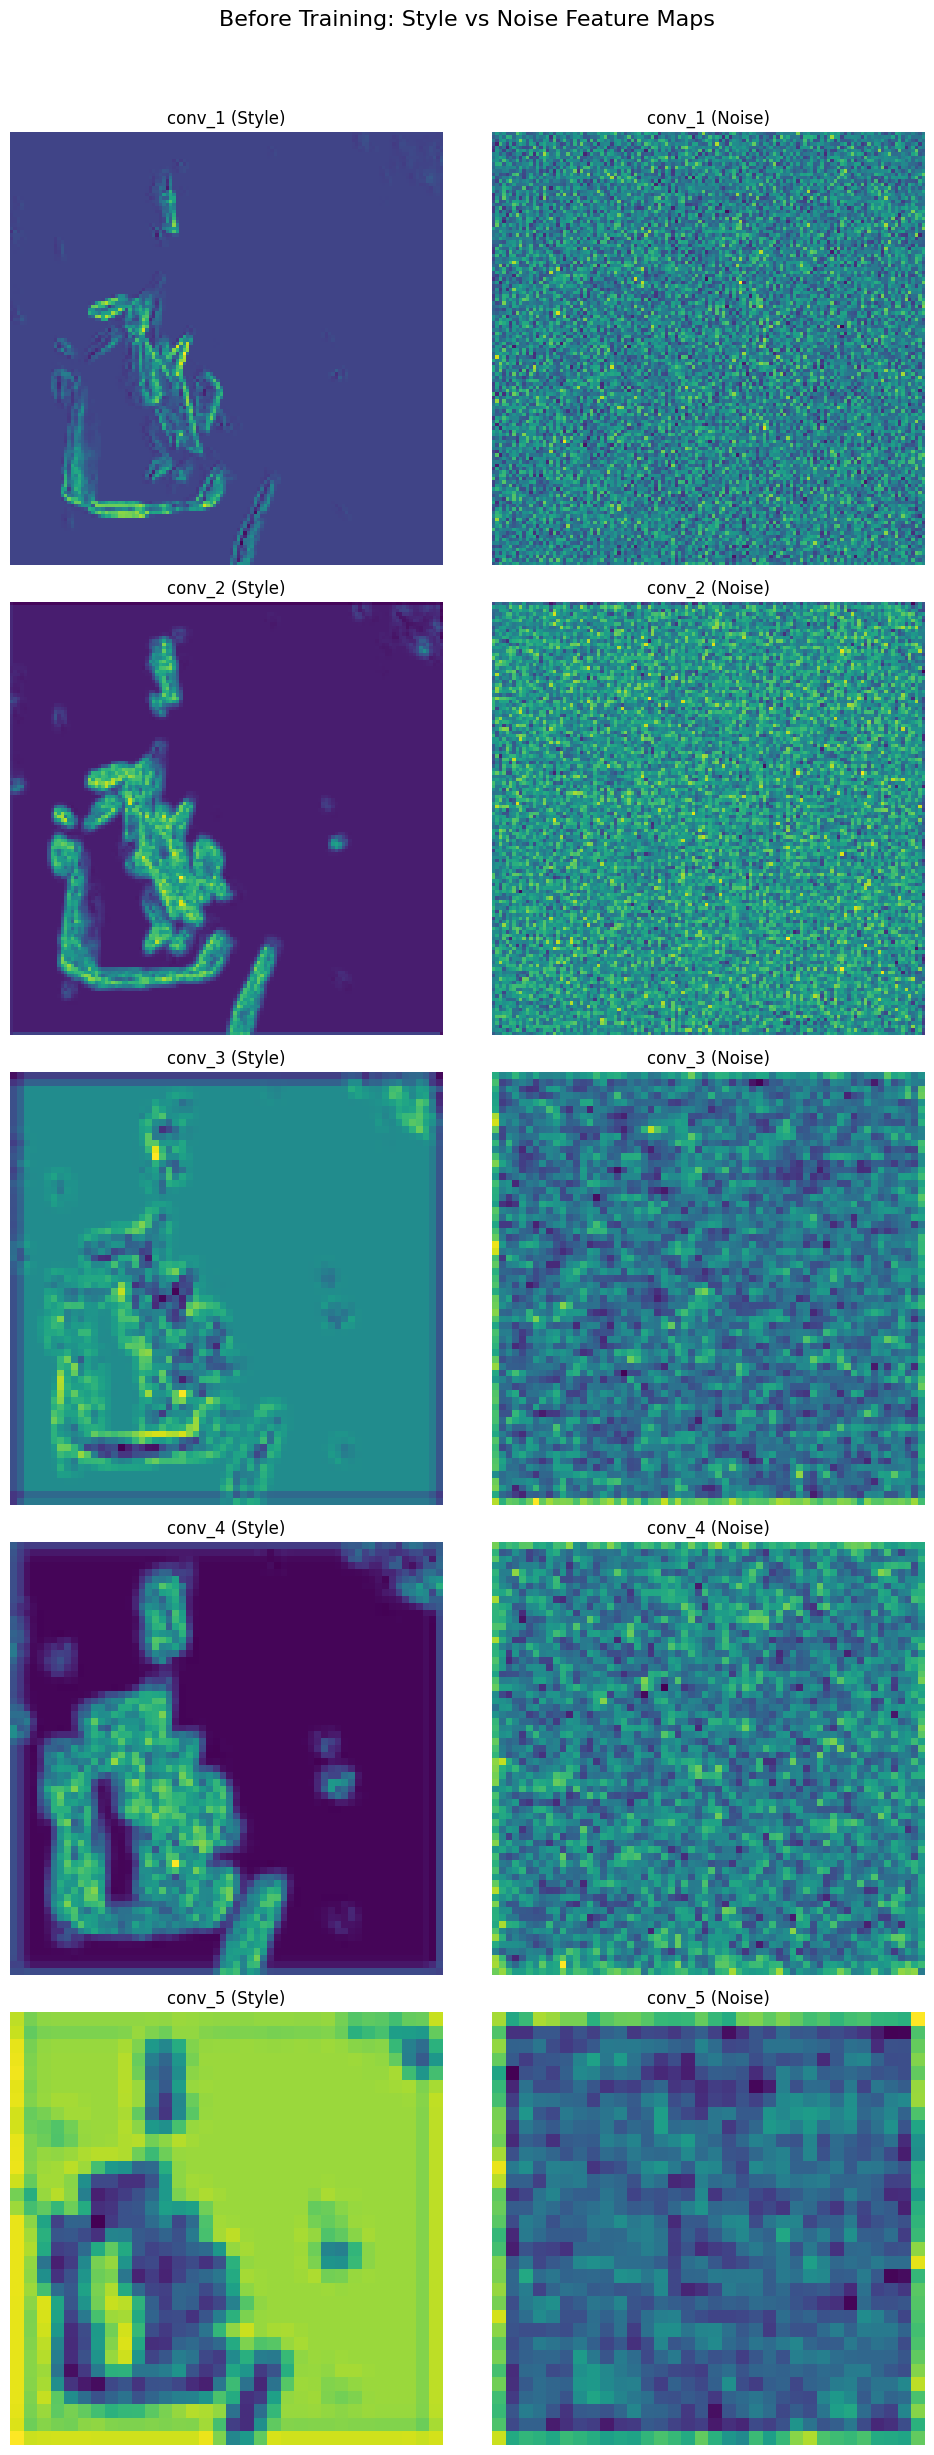

In [10]:
def visualize_feature_maps(style_results, noise_results, layers):
    fig, axes = plt.subplots(len(layers), 2, figsize=(10, 5 * len(layers)))
    fig.suptitle("Before Training: Style vs Noise Feature Maps", fontsize=16)

    if len(layers) == 1:
        axes = [axes]

    for i, layer in enumerate(layers):
        style_feature_map = style_results[layer].squeeze(0).cpu()
        style_mean_map = torch.mean(style_feature_map, dim=0).detach().numpy()
        axes[i][0].imshow(style_mean_map, cmap="viridis")
        axes[i][0].set_title(f"{layer} (Style)")
        axes[i][0].axis("off")

        noise_feature_map = noise_results[layer].squeeze(0).cpu()
        noise_mean_map = torch.mean(noise_feature_map, dim=0).detach().numpy()
        axes[i][1].imshow(noise_mean_map, cmap="viridis")
        axes[i][1].set_title(f"{layer} (Noise)")
        axes[i][1].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

layers_to_visualize = ["conv_1", "conv_2", "conv_3", "conv_4", "conv_5"]
visualize_feature_maps(style_tensor_results, noise_tensor_results, layers_to_visualize)

In [11]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=배치 크기(=1)
    # b=특징 맵의 수
    # (c,d)=특징 맵의 차원 (N=c*d)

    features = input.view(a * b, c * d)  # F_XL을 \hat F_XL로 크기 조정

    G = torch.mm(features, features.t())  # gram product를 계산

    # 각 특징 맵이 갖는 값의 수로 나누어
    # gram 행렬의 값을 '정규화'
    return G.div(a * b * c * d)

In [ ]:
style_tensor_output = style_tensor.clone().to(device)

style_tensor_results = {}
for name, layer in model.named_children():
    style_tensor_output = layer(style_tensor_output)
    style_tensor_results[name] = style_tensor_output

required_tensor = noise_tensor.clone().to(device)
required_tensor.requires_grad_(True)
optimizer = optim.SGD([required_tensor])

epochs = 30000
for epoch in range(epochs):
    optimizer.zero_grad()

    output_tensor = required_tensor
    with torch.no_grad():
        output_tensor.clamp_(0, 1) # replace

    loss = 0.0
    for name, layer in model.named_children():
        output_tensor = layer(output_tensor)

        if name == "conv_1":
            style_G = gram_matrix(style_tensor_results["conv_1"].detach())
            noise_G = gram_matrix(output_tensor)
            loss += F.mse_loss(noise_G, style_G)
        elif name == "conv_2":
            style_G = gram_matrix(style_tensor_results["conv_2"].detach())
            noise_G = gram_matrix(output_tensor)
            loss += F.mse_loss(noise_G, style_G)
        elif name == "conv_3":
            style_G = gram_matrix(style_tensor_results["conv_3"].detach())
            noise_G = gram_matrix(output_tensor)
            loss += F.mse_loss(noise_G, style_G)
        elif name == "conv_4":
            style_G = gram_matrix(style_tensor_results["conv_4"].detach())
            noise_G = gram_matrix(output_tensor)
            loss += F.mse_loss(noise_G, style_G)
        elif name == "conv_5":
            style_G = gram_matrix(style_tensor_results["conv_5"].detach())
            noise_G = gram_matrix(output_tensor)
            loss += F.mse_loss(noise_G, style_G)
        
    loss *= 1000000
    loss.backward()
    
    optimizer.step()

    if epoch % 50 == 0:
        print(f"{epoch}/{epochs} loss: {loss.item():.4f}")

    if loss == 0.0:
        print(f"Train finished")
        break

with torch.no_grad():
    output_tensor.clamp_(0, 1) # replace

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = model.to(device)
style_tensor_output = style_tensor.clone().to(device)
noise_tensor_output = required_tensor

style_tensor_results = {}
noise_tensor_results = {}
for name, layer in model.named_children():
    with torch.no_grad():
        style_tensor_output.clamp_(0, 1)
        noise_tensor_output.clamp_(0, 1)

    style_tensor_output = layer(style_tensor_output)
    noise_tensor_output = layer(noise_tensor_output)

    style_tensor_results[name] = style_tensor_output
    noise_tensor_results[name] = noise_tensor_output

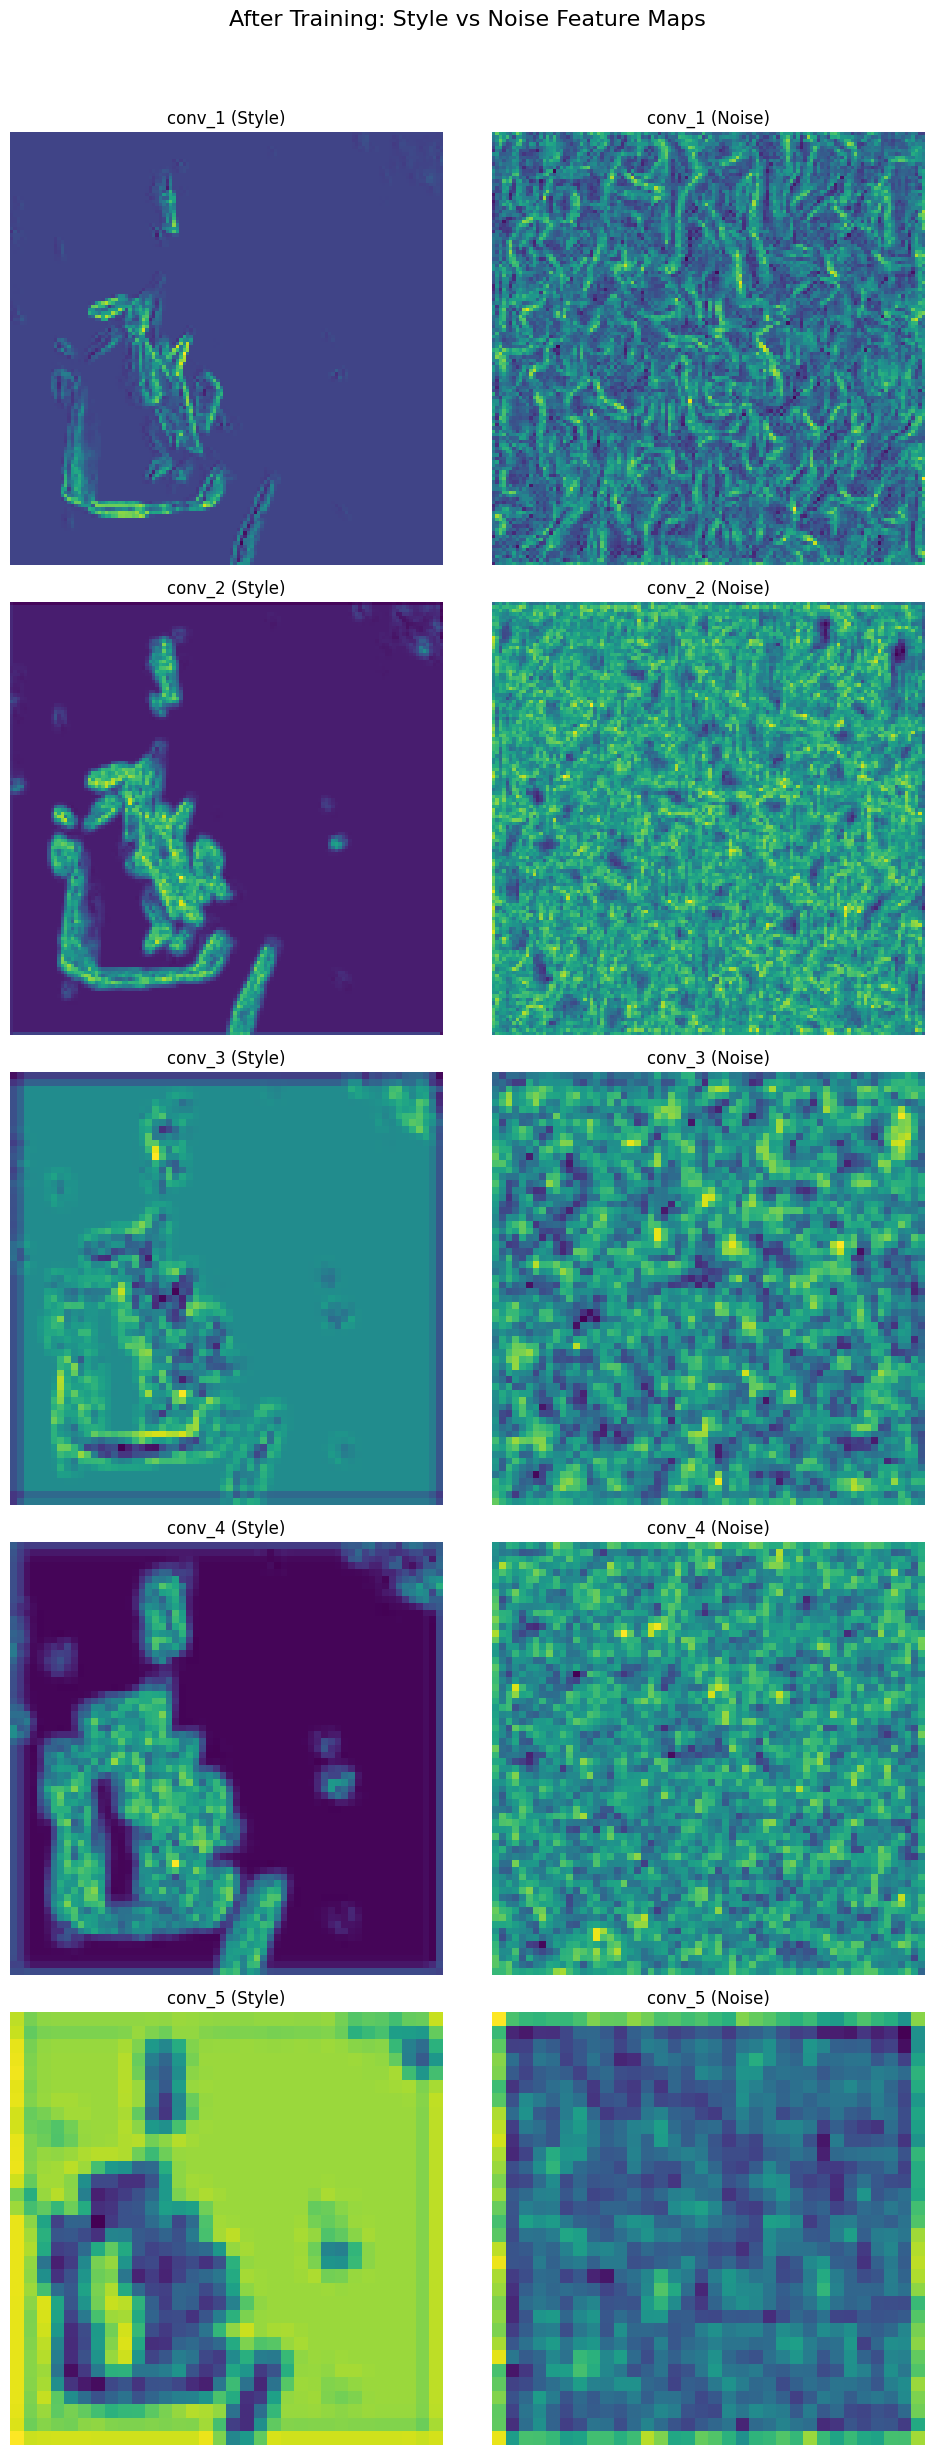

In [14]:
def visualize_feature_maps(style_results, noise_results, layers):
    fig, axes = plt.subplots(len(layers), 2, figsize=(10, 5 * len(layers)))
    fig.suptitle("After Training: Style vs Noise Feature Maps", fontsize=16)

    if len(layers) == 1:
        axes = [axes]

    for i, layer in enumerate(layers):
        style_feature_map = style_results[layer].squeeze(0).cpu()
        style_mean_map = torch.mean(style_feature_map, dim=0).detach().numpy()
        axes[i][0].imshow(style_mean_map, cmap="viridis")
        axes[i][0].set_title(f"{layer} (Style)")
        axes[i][0].axis("off")

        noise_feature_map = noise_results[layer].squeeze(0).cpu()
        noise_mean_map = torch.mean(noise_feature_map, dim=0).detach().numpy()
        axes[i][1].imshow(noise_mean_map, cmap="viridis")
        axes[i][1].set_title(f"{layer} (Noise)")
        axes[i][1].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

layers_to_visualize = ["conv_1", "conv_2", "conv_3", "conv_4", "conv_5"]
visualize_feature_maps(style_tensor_results, noise_tensor_results, layers_to_visualize)

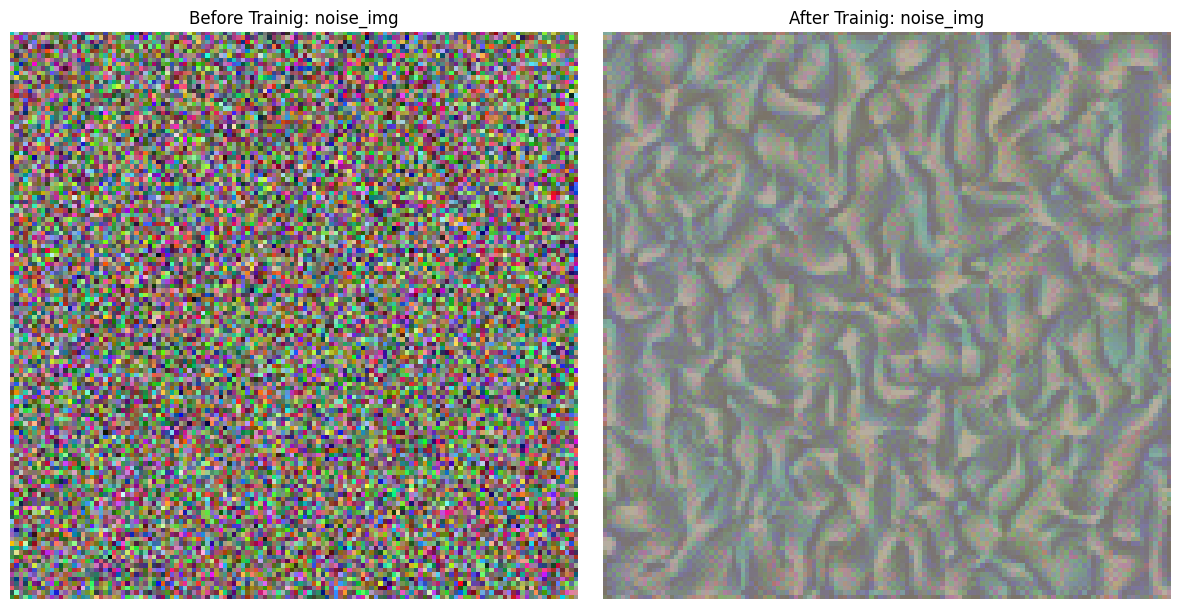

In [15]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(untransform(noise_tensor.squeeze(0)))
plt.title("Before Trainig: noise_img")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(untransform(required_tensor.squeeze(0)))
plt.title("After Trainig: noise_img")
plt.axis("off")

plt.tight_layout()
plt.show()